# COLAB PRE-REQS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/My\ Drive/datasets.zip 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/datasets.zip
   creating: datasets/
  inflating: datasets/README.md      
   creating: datasets/dev-articles/
  inflating: datasets/dev-articles/article730081389.txt  
  inflating: datasets/dev-articles/article730093263.txt  
  inflating: datasets/dev-articles/article730246508.txt  
  inflating: datasets/dev-articles/article730269378.txt  
  inflating: datasets/dev-articles/article738028498.txt  
  inflating: datasets/dev-arti

In [2]:
!pip install flair==0.4.3

     |████████████████████████████████| 184kB 2.9MB/s 
     |████████████████████████████████| 798kB 70.9MB/s 
     |████████████████████████████████| 184kB 69.5MB/s 
     |████████████████████████████████| 778kB 60.2MB/s 
     |████████████████████████████████| 1.0MB 47.7MB/s 
     |████████████████████████████████| 1.0MB 48.4MB/s 
     |████████████████████████████████| 860kB 54.7MB/s 
     |████████████████████████████████| 348kB 67.7MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=2a2dec6b23a026c8700971035fbda08e93642f4903a2d02e9c98c263c4b99421
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23258 sha256=ac60065526f8d7ec3dff0304e3421c0dccdb6109c14144d503311522eb86ace2
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Created wheel for sqlitedict: filename

In [3]:
!ls

datasets  drive  sample_data


# MODULE FUNCTIONS

In [0]:
''' IMPORTS '''

import os
import csv
import re
import sys 
sys.setrecursionlimit(10**6) 


def read_article(article_id):
    '''
    returns article raw text and span offsets given the article id
    '''
    
    article_fname = './datasets/train-articles/article' + str(article_id) + '.txt'
    label_fname = './datasets/train-labels-task1-span-identification/article' + str(article_id) + '.task1-SI.labels' 
    with open(article_fname, newline = '\n') as article:
        raw = article.read()
    with open(label_fname, newline = '\n') as label_file:
        labels = []
        labels_list = csv.reader(label_file, delimiter='\t')
        for x in labels_list:
            labels.append(x)
        spans = [[int(span_loc[1]), int(span_loc[2])] for span_loc in labels]
    return raw, spans


def get_spans(article_id):
    '''
    returns span texts
    '''
    
    raw, spans = read_article(article_id)
    span_texts = []
    for span in spans:
        span_texts.append(raw[span[0]:span[1]])
    return span_texts


def label_article_tokens(article_id):
    '''
    returns a binary 0/1 token-level lablled data propaganada span for train-set
    '''
    
    raw, spans = read_article(article_id)    #reading raw data and span locations
    token_list = raw.split()                 #splitting into space separated tokens
    
    first_letter_index = []                  #creating a list of charecter index of the first charecter of every token
    index = 0
    for token in token_list:
        success = False
        while not success:
            if raw[index] != '\n':
                first_letter_index.append(index)
                index += len(token) + 1
                success = True
            else:
                index += 1
         
    binary_labels = [0] * len(token_list)    #Assigning label of 1 (is propanagada) if first index of token lies in spans
    for i in range(len(first_letter_index)):
        for span in spans:
            if (span[0] <= first_letter_index[i] < span[1]):
                binary_labels[i] = 1
                
    labelled_tokens_list = []                #Creating common list of [token,label] entries
    for i in range(len(binary_labels)):
        labelled_tokens_list.append([token_list[i], binary_labels[i]])
        
    for i in range(len(labelled_tokens_list)-1):    
        if (labelled_tokens_list[i][0][0] == '\"') & (labelled_tokens_list[i+1][1] == 1):
            labelled_tokens_list[i][1] = 1   #Handling corner cases of quotation
    raw_new = ""
    for token in labelled_tokens_list:
        raw_new += token[0]+ " "
        
    assert (len(raw)==len(raw_new)), str("Cannot regenerate the raw text from these tokens " + str(len(raw)) + " != " + str(len(raw_new)))
    
    return labelled_tokens_list

def label_article_chars(article_id):
    '''
    returns a binary 0/1 char-level lablled data propaganada span for train-set (1: is_propangada)
    '''
    
    raw, spans = read_article(article_id)    #reading raw data and span locations
    label_list = []
    labels = [0] * len(raw)
    chars = list(raw)
    assert (len(labels)==len(chars)), "length mismatch in character and label sequence"
    
    for i in range(len(chars)):
        for span in spans:
            if span[0] <= i < span[1]:
                labels[i] = 1
                break
        label_list.append([chars[i], labels[i]])
        
    raw_new = ""
    for char in label_list:
        raw_new += char[0]
        
    assert (raw == raw_new), "unable to reporduce raw text from split characters"
        
    return label_list


#Word Level Data Processing
def getWordSpans(text):
    wordlist=[]
    def trans(text,pointer=0):
        if pointer==len(text)-1:
            return True
        else:
            while(not text[pointer].isalpha() and pointer<len(text)-1):
                pointer=pointer+1
            s=pointer
            while(text[pointer].isalpha() and pointer<len(text)-1):
                pointer=pointer+1
            wordlist.append([s,pointer])
            return trans(text,pointer)
    try:
        trans(text)
    except :
        return -1
    if(wordlist[-1][1]==wordlist[-1][0]):
        wordlist=wordlist[:-1]
    if(text[-1].isalpha()):
        wordlist[-1][1]+=1
    return wordlist

def getCharSpans(prediction,wordlist):
    charSpans=[]
    def getSpan(prediction,wordlist):
        for i in range(len(prediction)):
            if(i==0):
                if(prediction[i]==1):
                    charSpans.append(wordlist[0][0])
            elif(prediction[i]==0 and prediction[i-1]==1):
                charSpans.append(wordlist[i-1][1])
            elif(prediction[i]==1 and prediction[i-1]==0):
                charSpans.append(wordlist[i][0])
            if(i==len(prediction)-1 and prediction[i]==1):
                charSpans.append(wordlist[-1][1])
    getSpan(prediction,wordlist)
    return [[charSpans[i],charSpans[i+1]] for i in range(0,len(charSpans),2)]

def pred_span(text,prediction):
    wordlist=getWordSpans(text)
    return getCharSpans(prediction,wordlist)   

def getLabeledWords(article_id):
    text, spans = read_article(article_id)
    wordlist = getWordSpans(text)
    
    words = []
    labels = [0]*len(wordlist)
    for i in range(len(wordlist)):
        for span in spans:
            if (wordlist[i][0] in range(span[0], span[1]+1)) & (wordlist[i][1] in range(span[0], span[1]+1)):
                labels[i] = 1
                break
    for word in wordlist:
        words.append(text[word[0]:word[1]])
        
    assert (len(words)==len(labels))
    
    return words, labels

# IMPORTS

In [0]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import os
import time
import matplotlib.pyplot as plt

from flair.embeddings import WordEmbeddings, BytePairEmbeddings, StackedEmbeddings, Sentence
%matplotlib inline

In [0]:
#SEED

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

In [7]:
#GPU CHECK

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [0]:
article_directory = './datasets/train-articles/'
label_directory = './datasets/train-labels-task1-span-identification/'

In [0]:
article_fnames = os.listdir(article_directory)
article_ids = [int(fname[7:16]) for fname in article_fnames]

In [0]:
data_raw = [read_article(idx) for idx in article_ids]

# DATASET

In [11]:
# init embedding
embedding = StackedEmbeddings(
    [
        # standard FastText word embeddings for English
        WordEmbeddings('en'),
        # Byte pair embeddings for English
        BytePairEmbeddings('en'),
    ]
)

2019-12-23 20:13:35,733 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.3/en-fasttext-news-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpalnls64m


100%|██████████| 1200000128/1200000128 [00:51<00:00, 23475158.56B/s]

2019-12-23 20:14:27,392 copying /tmp/tmpalnls64m to cache at /root/.flair/embeddings/en-fasttext-news-300d-1M.vectors.npy


2019-12-23 20:14:31,749 removing temp file /tmp/tmpalnls64m
2019-12-23 20:14:32,356 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.3/en-fasttext-news-300d-1M not found in cache, downloading to /tmp/tmpsf8bnym1


100%|██████████| 54600983/54600983 [00:03<00:00, 16428899.22B/s]

2019-12-23 20:14:36,165 copying /tmp/tmpsf8bnym1 to cache at /root/.flair/embeddings/en-fasttext-news-300d-1M
2019-12-23 20:14:36,213 removing temp file /tmp/tmpsf8bnym1



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs100000.model


100%|██████████| 1987533/1987533 [00:00<00:00, 2797521.53B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs100000.d50.w2v.bin.tar.gz


100%|██████████| 19357958/19357958 [00:01<00:00, 12842296.70B/s]


In [12]:
start_time = time.time()
max_len = 16

X_right = []
X_left = []
y = []
pad_embed = torch.zeros(1,400)

for idx in article_ids:   
    words, labels = getLabeledWords(idx)
    word_sent = [(Sentence(word)) for word in words]
    for sent in word_sent:
      embedding.embed(sent)
    word_embeds = [sent[0].embedding.cpu().reshape(1, 400) for sent in word_sent]
    
    for i in range(len(word_embeds)):
        y.append(labels[i])
        
        x_r = word_embeds[i:]
        x_l = word_embeds[:i+1]
        
        if len(x_r)>max_len:
            x_r = x_r[:max_len]
        elif len(x_r)<max_len:
            x_r = x_r + [pad_embed]*(max_len-len(x_r))
        
        if len(x_l)>max_len:
            x_l = x_l[-max_len:]
        elif len(x_l)<max_len:
            x_l = [pad_embed]*(max_len-len(x_l)) + x_l
            
        X_right.append(x_r[::-1])
        X_left.append(x_l)

print("Done in ", time.time()-start_time, " seconds")

Done in  68.66840100288391  seconds


In [0]:
#FASTTEXT DATASET

class FastTextTdLstmDataset(Dataset):
    def __init__(self, x_right_seqs, x_left_seqs, y, transform=None):
        self.x_right_seqs = x_right_seqs
        self.x_left_seqs = x_left_seqs
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.x_right_seqs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x_r, x_l = self.x_right_seqs[idx], self.x_left_seqs[idx]
        
        x_r_ftxt, x_l_ftxt = torch.cat(x_r, dim=0), torch.cat(x_l, dim=0)
        x_target_ftxt = torch.cat([x_r[-1]]*len(x_r))
        x_r_ftxt, x_l_ftxt = torch.cat((x_r_ftxt, x_target_ftxt), dim=1), torch.cat((x_l_ftxt, x_target_ftxt), dim=1)
        y_ = torch.tensor(self.y[idx])
        
        return x_r_ftxt, x_l_ftxt, y_

In [0]:
#ITERATORS

train_dataset = FastTextTdLstmDataset(X_right, X_left, y)
train_loader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=4)

# MODEL

In [0]:
#TD-LSTM

class WordTDLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(WordTDLSTM, self).__init__()
        
        #Input Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        #Defining Layers
        self.lstm_l = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.lstm_r = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sequence_r, sequence_l):
        #LSTM Outputs
        __, (lstm_r_out, _) = self.lstm_r(sequence_r)                 #Right LSTM output
        __, (lstm_l_out, _) = self.lstm_l(sequence_l)                 #Left LSTM output

        #FC Layer
        fc_input = torch.cat((lstm_r_out, lstm_l_out), dim=2)    #Concatenating outputs from last cells of both LSTMs
        fc_input = fc_input.reshape(fc_input.shape[1], fc_input.shape[2])
        out = self.fc1(fc_input)
        out = self.fc2(out)
        out = self.sigmoid(out)                                  #Final sigmoid output
        
        return out

In [0]:
model = WordTDLSTM(input_size=400*2, hidden_size=256)
model = model.to(device)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, eps=1e-5)
criterion = nn.BCELoss()

In [18]:
#TRAINING

epochs = 20
train_loss = []
start_time = time.time()

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs_r, inputs_l, labels = data
        inputs_r, inputs_l, labels = inputs_r.to(device), inputs_l.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs_r.float(), inputs_l.float())
        loss = criterion(outputs.flatten(), labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000, time.time()-start_time))
            train_loss.append(running_loss / 1000)
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.371 time: 10.106
[1,  2000] loss: 0.348 time: 19.962
[1,  3000] loss: 0.345 time: 29.422
[1,  4000] loss: 0.342 time: 38.860
[1,  5000] loss: 0.337 time: 48.160
[1,  6000] loss: 0.327 time: 57.626
[1,  7000] loss: 0.322 time: 66.825
[1,  8000] loss: 0.321 time: 76.037
[1,  9000] loss: 0.316 time: 85.218
[1, 10000] loss: 0.310 time: 94.318
[2,  1000] loss: 0.290 time: 112.109
[2,  2000] loss: 0.282 time: 121.704
[2,  3000] loss: 0.271 time: 131.126
[2,  4000] loss: 0.267 time: 140.615
[2,  5000] loss: 0.255 time: 149.814
[2,  6000] loss: 0.250 time: 159.120
[2,  7000] loss: 0.243 time: 168.352
[2,  8000] loss: 0.231 time: 177.710
[2,  9000] loss: 0.221 time: 186.890
[2, 10000] loss: 0.212 time: 196.234
[3,  1000] loss: 0.153 time: 214.349
[3,  2000] loss: 0.159 time: 223.902
[3,  3000] loss: 0.148 time: 233.216
[3,  4000] loss: 0.142 time: 242.611
[3,  5000] loss: 0.143 time: 252.185
[3,  6000] loss: 0.137 time: 261.322
[3,  7000] loss: 0.139 time: 270.594
[3,  8000] 

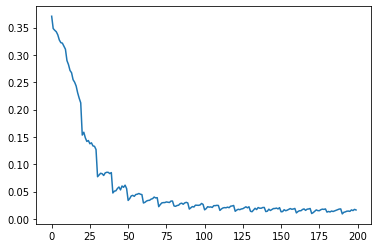

In [19]:
plt.plot(train_loss)

In [20]:
torch.save(model, '/content/drive/My Drive/WordTDLSTM_fasttext_24_12_19.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type WordTDLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
